In [9]:
import utils, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)

# Random Forests

## Data

Census Income Data Set: http://mlr.cs.umass.edu/ml/datasets/Census+Income

Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

In [3]:
df_raw = pd.read_csv('data/census_train.csv')
df_test = pd.read_csv('data/census_test.csv')
df_raw.shape, df_test.shape

((32561, 15), (16281, 15))

In [5]:
df_raw.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


## Ejercicio 1: Preprocesar los datos

In [6]:
# 1. Convertir las columnas a tipo "category",
#    pero solo las que tengan más de "max_dummies" valores únicos.
#    Las variables "max_dummies" o menos valores únicos las transformaremos con "pd.get_dummies".
max_dummies = 7
cat_dict = {}

for n,col in df_raw.items():
    if not pd.api.types.is_numeric_dtype(col) and (col.nunique() > max_dummies):
        # Transforma la variable a tipo category
        df_raw[n] = col.astype('category')

        # Actualiza cat_dict
        cat_dict[n] = {i+1:e for i,e in enumerate(df_raw[n].cat.categories)}
        
        
df_raw.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status      object
occupation        category
relationship        object
race                object
sex                 object
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
label               object
dtype: object

In [7]:
# 2. El dataset no tiene data faltante, por que vamos directo a trasnformar
#    las columnas categóricas a numéricas.
df = df_raw.copy()

# Convertir cada columna categórica a numérica
for n,col in df.items():
    if pd.api.types.is_categorical_dtype(col):
        df[n] = col.cat.codes+1
        
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,8,77516,10,13,Never-married,2,Not-in-family,White,Male,2174,0,40,40,<=50K
1,50,7,83311,10,13,Married-civ-spouse,5,Husband,White,Male,0,0,13,40,<=50K
2,38,5,215646,12,9,Divorced,7,Not-in-family,White,Male,0,0,40,40,<=50K


In [8]:
# 3. Separamos las variables dependientes e independientes y
#    aplicamos dummies.
#    * La variable dependiente no necesita ser numérica.
x = pd.get_dummies(df.drop('label', axis=1))
y = df['label']

x.head(2)

,age,workclass,fnlwgt,education,education-num,occupation,capital-gain,capital-loss,hours-per-week,native-country,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,39,8,77516,10,13,2,2174,0,40,40,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,50,7,83311,10,13,5,0,0,13,40,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1


In [10]:
# 4. Train-validation split
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape: (26048, 30)
Validation shape: (6513, 30)


## Entrenando un Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=10, n_jobs=-1)
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
# Vamos a definir una función para ver los resultados del entrenamiento.
def score():
    print(f'Train score      = {m.score(x_train, y_train):.4}')
    print(f'Validation score = {m.score(x_val, y_val):.4}')
    
score()    

Train score      = 0.9874
Validation score = 0.8531


In [50]:
# El parámetro "estimators_" del modelo, contiene los árboles entrenados.
# Vamos a obtener las prediciones de cada árbol
preds = np.stack([t.predict(x_val) for t in m.estimators_])
print(preds.shape)
preds

(10, 6513)


array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

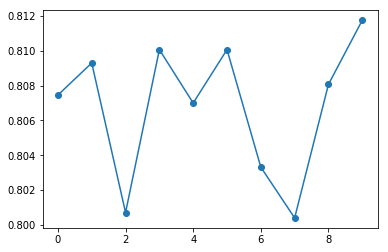

In [83]:
# Veamos el score de cada árbol
from sklearn.metrics import accuracy_score

accs = [accuracy_score(y_val==' >50K', p) for p in preds]
plt.plot(accs, '-o');

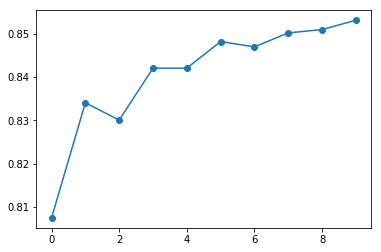

In [95]:
# Ahora veamos el score acumulado
acum_accs = [accuracy_score(y_val==' >50K', np.mean(preds[:i+1,:], axis=0) > 0.5) for i in range(len(preds))]
plt.plot(acum_accs, '-o');

In [161]:
# Usemos los árboles para obtener una predicción con una estimación de confianza.
sample = x_val.sample(1)

pred = np.stack([t.predict(sample) for t in m.estimators_])

pred.mean() > 0.5, pred.std()

(True, 0.41758232721225164)

## Out-of-bag (OOB) score

¿Nuestra validación es peor en el conjunto de validación debido a overfitting, o es porque el conjunto de validación es para un período de tiempo diferente, o un poco de ambos?

Con la información existente que hemos mostrado, no podemos decirlo. Sin embargo, los bosques aleatorios tienen un truco muy ingenioso: oobs core (error fuera de la bolsa).

La idea es calcular el error en el conjunto de entrenamiento, donde la predicción de cada elemento se haga sólo por los árboles que no lo incluyeron en su entrenamiento. Esto nos permite ver si el modelo se ajusta demasiado, sin necesidad de un conjunto de validación por separado.

In [102]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [103]:
m.oob_score_

0.8465525184275184

In [273]:
# Vamos a modificar la función score, para incluir el oob score.
def score():
    print(f'Train score      = {m.score(x_train, y_train):.4}')
    print(f'Validation score = {m.score(x_val, y_val):.4}')
    if hasattr(m, 'oob_score_'): print(f'OOB score        = {m.oob_score_:.4}')
    
score()    

Train score      = 0.5539
Validation score = 0.5383


**Algunos paŕametros importantes al crear un Random Forest:**
* n_estimators: cantidad de árboles
* max_depth: la máxima profundidad de cada árbol
* min_samples_leaf: cantidad de muestras mínimas para que puede tener una rama.
* max_features: cantidad de columnas que ve cada árbol.

# Regresión

House Sales Prediction Data Set: https://www.kaggle.com/harlfoxem/housesalesprediction/home

Abstract: This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

- **id**: a notation for a house
- **date**: Date house was sold
- **price**: Price is prediction target
- **bedrooms**: Number of Bedrooms/House
- **bathrooms**: Number of bathrooms/bedrooms
- **sqft_living**: square footage of the home
- **sqft_lot**: square footage of the lot
- **floors**: Total floors (levels) in house
- **waterfront**: House which has a view to a waterfront
- **view**: Has been viewed
- **condition**: How good the condition is ( Overall )
- **grade**: overall grade given to the housing unit, based on King County grading system
- **sqft_above**: square footage of house apart from basement
- **sqft_basement**: square footage of the basement
- **yr_built**: Built Year
- **yr_renovated**: Year when house was renovated
- **zipcode**: zip
- **lat**: Latitude coordinate
- **long**: Longitude coordinate
- **sqft_living15**: Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
- **sqft_lot15**: lotSize area in 2015(implies-- some renovations)

In [261]:
df_raw = pd.read_csv('data/kc_house_data.csv', parse_dates=['date'])
print(df_raw.shape)
df_raw.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Preprocess

### Fechas

In [262]:
df_raw.date.describe()

count                   21613
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

In [263]:
# Podemos usar "dt" para acceder a los métodos de fechas.
df_raw.date.dt.year.head()

0    2014
1    2014
2    2015
3    2014
4    2015
Name: date, dtype: int64

In [264]:
# 1. Algunos parámetros útiles que se pueden extraer de fechas
date_attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
             'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

for n in date_attr:
    df_raw['date_' + n] = getattr(df_raw['date'].dt, n.lower())

# 2. Una representación numérica de la fecha
df_raw['date_elapsed'] = df_raw['date'].astype(np.int64) // 10 ** 9


# 3. Eliminamos la variable date
df_raw.drop('date', axis=1, inplace=True)

df_raw.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_Year,date_Month,date_Week,date_Day,date_Dayofweek,date_Dayofyear,date_Is_month_end,date_Is_month_start,date_Is_quarter_end,date_Is_quarter_start,date_Is_year_end,date_Is_year_start,date_elapsed
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,42,13,0,286,False,False,False,False,False,False,1413158400
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,50,9,1,343,False,False,False,False,False,False,1418083200
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,9,25,2,56,False,False,False,False,False,False,1424822400
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,50,9,1,343,False,False,False,False,False,False,1418083200
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,8,18,2,49,False,False,False,False,False,False,1424217600


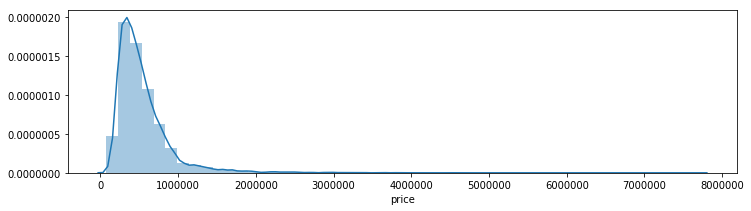

In [265]:
plt.figure(figsize=(12,3))
sns.distplot(df_raw.price);

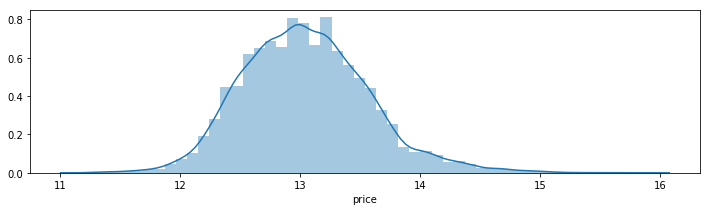

In [266]:
plt.figure(figsize=(12,3))
sns.distplot(np.log(df_raw.price));

Es importante tener en cuenta lo que estamos evaluando, en el caso de precios es bastante común tener mayor interes en el ratio del error que en el valor del error.

* La predicción fallo en S/.10 vs la predicción fallo en 10%.
* Un error de S/.100 en un precio de S/.1,000,000 vs un error de S/.100 en un precio de S/.1000.

Por eso vamos a considerar el log del precio.

In [267]:
df_raw.price = np.log(df_raw.price)
df_raw.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_Year,date_Month,date_Week,date_Day,date_Dayofweek,date_Dayofyear,date_Is_month_end,date_Is_month_start,date_Is_quarter_end,date_Is_quarter_start,date_Is_year_end,date_Is_year_start,date_elapsed
0,7129300520,12.309982,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,42,13,0,286,False,False,False,False,False,False,1413158400
1,6414100192,13.195614,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,50,9,1,343,False,False,False,False,False,False,1418083200
2,5631500400,12.100712,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,9,25,2,56,False,False,False,False,False,False,1424822400
3,2487200875,13.311329,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,50,9,1,343,False,False,False,False,False,False,1418083200
4,1954400510,13.142166,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,8,18,2,49,False,False,False,False,False,False,1424217600


### Train-validation split

In [268]:
x = df_raw.drop('price', axis=1)
y = df_raw['price']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (17290, 32)
Validation shape: (4323, 32)


## Entrenar un árbol de regresión

In [298]:
from sklearn.tree import DecisionTreeRegressor

m = DecisionTreeRegressor(max_depth=2)
m.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [299]:
# m.score retorna el coeficiente de determinación de la predicción
score()

Train score      = 0.5539
Validation score = 0.5383


In [301]:
# veamos el mse
from sklearn.metrics import mean_squared_error
mean_squared_error(y_val, m.predict(x_val))

0.1315939214603435

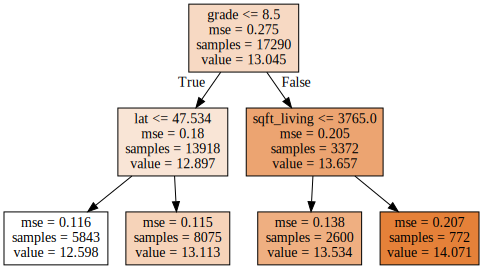

In [302]:
utils.draw_tree(m, x_train)

## Calculando los valores del árbol

In [308]:
y_train.mean()

13.045165229875252

In [310]:
((y_train - y_train.mean())**2).mean()

0.27543630032941563

In [317]:
y_train[x_train['grade'] <= 8.5].mean()

12.896989327477723

In [318]:
((y_train[x_train['grade'] <= 8.5] - y_train[x_train['grade'] <= 8.5].mean())**2).mean()

0.17996169928110842

In [319]:
y_train[x_train['grade'] > 8.5].mean()

13.656764343033267

In [320]:
((y_train[x_train['grade'] > 8.5] - y_train[x_train['grade'] > 8.5].mean())**2).mean()

0.2048319724186241

## Usando un random forest

In [321]:
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [322]:
score()

Train score      = 0.9834
Validation score = 0.8871
OOB score        = 0.8797


# Interpretación del modelo

## Feature importance

### Sklearn feature importance

In [336]:
m.feature_importances_

array([6.83055009e-03, 2.14194021e-03, 4.21119217e-03, 1.79452616e-01,
       1.30988350e-02, 1.05551901e-03, 6.11671053e-03, 7.26645847e-03,
       4.34003814e-03, 3.35369959e-01, 1.24906662e-02, 2.42405898e-03,
       1.91277750e-02, 1.13773301e-03, 9.10574879e-03, 2.92844453e-01,
       4.24919499e-02, 2.32927928e-02, 1.20948501e-02, 2.41836069e-04,
       1.44851626e-03, 3.14246754e-03, 5.14747860e-03, 2.60536096e-03,
       4.11864889e-03, 1.29199215e-04, 8.88601303e-05, 8.02550719e-05,
       6.80338781e-05, 2.17115610e-06, 0.00000000e+00, 8.03332595e-03])

In [342]:
imp = pd.DataFrame({'cols':x_train.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
imp.style.bar()

,cols,imp
9,grade,0.33537
15,lat,0.292844
3,sqft_living,0.179453
16,long,0.0424919
17,sqft_living15,0.0232928
12,yr_built,0.0191278
4,sqft_lot,0.0130988
10,sqft_above,0.0124907
18,sqft_lot15,0.0120949
14,zipcode,0.00910575


### Una mejor forma de obtener feature importance

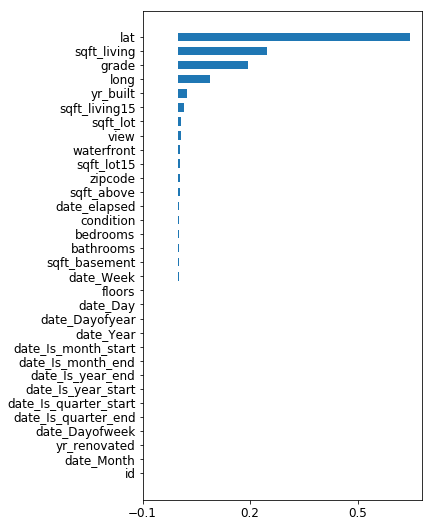

In [344]:
from rfpimp import importances, plot_importances

imp = importances(m, x_val, y_val)
plot_importances(imp, figsize=(5,9));

## Partial Dependence Plot

## Tree interpreter

## Ejercicio 2: Utilizar los métodos de interpretación en el Census Income Data Set

# Debilidades de Random Forest